In [1]:
import pathlib
from datetime import datetime, timedelta
import warnings

import numpy as np
import pandas as pd
import xarray as xr
from iris.analysis.cartography import area_weights
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import intake
import healpy
import tobac


In [2]:
cat = intake.open_catalog("https://data.nextgems-h2020.eu/catalog.yaml")
cat.IFS['IFS_9-FESOM_5-production']['2D_hourly_healpix512_2020s']

2D_hourly_healpix512_2020s:
  args:
    consolidated: false
    drop_variables:
    - sst
    - ci
    - 10si
    - 100si
    urlpath:
    - reference::/work/bm1235/a270046/cycle4/gribscan_1h1d_2D_healpix512/jsons.2020/sfc.dir/atm2d.json
    - reference::/work/bm1235/a270046/cycle4/gribscan_1h1d_2D_healpix512/jsons.2021/sfc.dir/atm2d.json
    - reference::/work/bm1235/a270046/cycle4/gribscan_1h1d_2D_healpix512/jsons.2022/sfc.dir/atm2d.json
    - reference::/work/bm1235/a270046/cycle4/gribscan_1h1d_2D_healpix512/jsons.2023/sfc.dir/atm2d.json
    - reference::/work/bm1235/a270046/cycle4/gribscan_1h1d_2D_healpix512/jsons.2024/sfc.dir/atm2d.json
    - reference::/work/bm1235/a270046/cycle4/gribscan_1h1d_2D_healpix512/jsons.2025/sfc.dir/atm2d.json
    - reference::/work/bm1235/a270046/cycle4/gribscan_1h1d_2D_healpix512/jsons.2026/sfc.dir/atm2d.json
    - reference::/work/bm1235/a270046/cycle4/gribscan_1h1d_2D_healpix512/jsons.2027/sfc.dir/atm2d.json
    - reference::/work/bm1235/a270046/cyc

In [3]:
dataset = cat.IFS['IFS_9-FESOM_5-production']['2D_hourly_healpix512_2020s'](chunks="auto", consolidated=False).to_dask()
dataset

/home/b/b382728/miniconda3/envs/tobac/lib/python3.11/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


<xarray.Dataset> Size: 125TB
Dimensions:  (time: 87226, value: 3145728)
Coordinates:
    lat      (value) float64 25MB dask.array<chunksize=(3145728,), meta=np.ndarray>
    lon      (value) float64 25MB dask.array<chunksize=(3145728,), meta=np.ndarray>
  * time     (time) datetime64[ns] 698kB 2020-01-20 ... 2030-01-01
Dimensions without coordinates: value
Data variables: (12/57)
    10u      (time, value) float64 2TB dask.array<chunksize=(5, 3145728), meta=np.ndarray>
    10v      (time, value) float64 2TB dask.array<chunksize=(5, 3145728), meta=np.ndarray>
    2d       (time, value) float64 2TB dask.array<chunksize=(5, 3145728), meta=np.ndarray>
    2t       (time, value) float64 2TB dask.array<chunksize=(5, 3145728), meta=np.ndarray>
    blh      (time, value) float64 2TB dask.array<chunksize=(5, 3145728), meta=np.ndarray>
    chnk     (time, value) float64 2TB dask.array<chunksize=(5, 3145728), meta=np.ndarray>
    ...       ...
    tp       (time, value) float64 2TB dask.array<chunksize=(5, 3145728), meta=np.ndarray>
    tprate   (time, value) float64 2TB dask.array<chunksize=(5, 3145728), meta=np.ndarray>
    tsr      (time, value) float64 2TB dask.array<chunksize=(5, 3145728), meta=np.ndarray>
    tsrc     (time, value) float64 2TB dask.array<chunksize=(5, 3145728), meta=np.ndarray>
    ttr      (time, value) float64 2TB dask.array<chunksize=(5, 3145728), meta=np.ndarray>
    ttrc     (time, value) float64 2TB dask.array<chunksize=(5, 3145728), meta=np.ndarray>
Attributes:
    edition:            2
    centre:             ecmf
    centreDescription:  European Centre for Medium-Range Weather Forecasts
    subCentre:          1003
    history:            🪄🧙‍♂️🔮 magic dataset assembly provided by gribscan.IF...

In [4]:
dataset.ttr

<xarray.DataArray 'ttr' (time: 87226, value: 3145728)> Size: 2TB
dask.array<concatenate, shape=(87226, 3145728), dtype=float64, chunksize=(5, 3145728), chunktype=numpy.ndarray>
Coordinates:
    lat      (value) float64 25MB dask.array<chunksize=(3145728,), meta=np.ndarray>
    lon      (value) float64 25MB dask.array<chunksize=(3145728,), meta=np.ndarray>
  * time     (time) datetime64[ns] 698kB 2020-01-20 ... 2030-01-01
Dimensions without coordinates: value
Attributes: (12/15)
    paramId:                    179
    dataType:                   fc
    numberOfPoints:             3145728
    typeOfLevel:                nominalTop
    stepUnits:                  1
    stepType:                   accum
    ...                         ...
    name:                       Top net long-wave (thermal) radiation
    cfName:                     toa_outgoing_longwave_flux
    cfVarName:                  ttr
    missingValue:               9999
    NV:                         0
    gridDefinitionDescription:  150

In [5]:
dataset.ttr.data

dask.array<concatenate, shape=(87226, 3145728), dtype=float64, chunksize=(5, 3145728), chunktype=numpy.ndarray>

In [6]:
lon = xr.DataArray(
    np.arange(0.05, 360, 0.1), dims=("lon",), name="lon", attrs=dict(units="degrees", standard_name="longitude")
)
lat = xr.DataArray(
    np.arange(59.95, -60, -0.1), dims=("lat",), name="lat", attrs=dict(units="degrees", standard_name="latitude")
)

pix = xr.DataArray(
    healpy.ang2pix(512, *np.meshgrid(lon, lat), nest=True, lonlat=True),
    coords=(lat, lon),
)


In [7]:
def get_tb(olr):
    """
    This function converts outgoing longwave radiation to brightness temperatures.

    Args:
        olr(xr.DataArray or numpy array): 2D field of model output with OLR

    Returns:
        tb(xr.DataArray or numpy array): 2D field with estimated brightness temperatures
    """
    # constants
    aa = 1.228
    bb = -1.106e-3  # K−1
    # Planck constant
    sigma = 5.670374419e-8  # W⋅m−2⋅K−4

    # flux equivalent brightness temperature
    Tf = (abs(olr) / sigma) ** (1.0 / 4)
    tb = (((aa**2 + 4 * bb * Tf) ** (1.0 / 2)) - aa) / (2 * bb)
    return tb

In [8]:
start_date = datetime(2021,1,1)
end_date = start_date + timedelta(days=1)

In [9]:
%%time
olr = dataset.ttr.drop_vars(["lat", "lon"])\
    .sel(time=slice(start_date, end_date - timedelta(minutes=1)))\
    .compute().isel(value=pix) / -3.6e3
# The previous step results in an array that is not in contiguous memory order, which slows down all further calculations
# By ravelling then reshaping, we get it back in contiguous order
# Note that if we called "compute" after regridding, it would be in the correct order, but doing so is much slower (~60s)
olr.data = olr.values.ravel().reshape(olr.shape) 
# IFS has duplicate time coords at restarts (with missing data), so we find and drop these using np.unique
olr = olr.isel(time=np.unique(olr.time, return_index=True)[1])
olr.attrs = dataset.ttr.attrs
olr.attrs["units"] = "W m**-2"

CPU times: user 2.45 s, sys: 2.28 s, total: 4.72 s
Wall time: 3.13 s


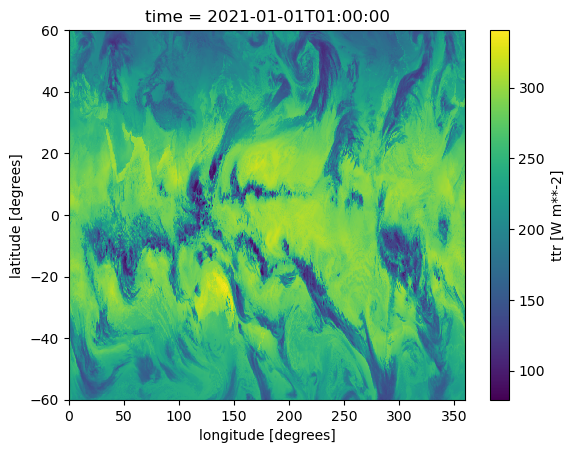

In [10]:
olr[1].plot()

In [11]:
bt = get_tb(olr)

In [12]:
dt = 3600  # in seconds
dxy = 11100  # in meter (for Latitude)

parameters_features = dict(
    dxy=dxy,
    threshold=[241, 233, 225],
    n_min_threshold=10,
    min_distance=10*dxy,
    target="minimum",
    position_threshold="center",
    PBC_flag="hdim_2",
    statistic={"feature_min_BT": np.nanmin},
)

parameters_segments = dict(
    threshold=241, target="minimum", PBC_flag="hdim_2", seed_3D_flag="box", seed_3D_size=11, statistic={"mean_BT": np.nanmean},
)
    
parameters_tracking = dict(
    d_max=10*dxy,
    method_linking="predict",
    adaptive_stop=0.2,
    adaptive_step=0.95,
    stubs=2,
    memory=0,
    PBC_flag="hdim_2",
    min_h2=0,
    max_h2=3600,
)

parameters_merge = dict(
    distance=dxy*10, frame_len=2, PBC_flag="hdim_2", min_h1=0, max_h1=1200, min_h2=0, max_h2=3600,
)


In [13]:
print(datetime.now(), f"Commencing feature detection", flush=True)
features = tobac.feature_detection_multithreshold(
    bt.to_iris(),
    **parameters_features,
)

2024-03-10 16:03:45.972826 Commencing feature detection


In [14]:
features

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature_min_BT,feature,time,timestr,latitude,longitude
0,0,2,0.333333,187.833331,12,241,239.860467,1,2021-01-01 00:00:00,2021-01-01 00:00:00,59.916667,18.833333
1,0,6,26.734449,1247.682511,1913,241,234.611967,2,2021-01-01 00:00:00,2021-01-01 00:00:00,57.276555,124.818251
2,0,7,8.115169,1324.671353,356,241,234.351336,3,2021-01-01 00:00:00,2021-01-01 00:00:00,59.138483,132.517135
3,0,9,10.455078,2727.950685,512,241,237.967096,4,2021-01-01 00:00:00,2021-01-01 00:00:00,58.904492,272.845068
4,0,10,2.600000,2796.300009,50,241,239.842768,5,2021-01-01 00:00:00,2021-01-01 00:00:00,59.690000,279.680001
...,...,...,...,...,...,...,...,...,...,...,...,...
18376,23,1797,927.183333,3326.522127,360,225,219.808764,18377,2021-01-01 23:00:00,2021-01-01 23:00:00,-32.768333,332.702213
18377,23,1803,944.083333,2410.250074,156,225,220.189336,18378,2021-01-01 23:00:00,2021-01-01 23:00:00,-34.458333,241.075007
18378,23,1806,1005.200000,2901.387504,80,225,219.23063,18379,2021-01-01 23:00:00,2021-01-01 23:00:00,-40.570000,290.188750
18379,23,1807,1018.904762,2897.428572,21,225,222.542463,18380,2021-01-01 23:00:00,2021-01-01 23:00:00,-41.940476,289.792857


In [15]:
features["feature_min_BT"] = features["feature_min_BT"].to_numpy().astype(float)

print(datetime.now(), f"Commencing segmentation", flush=True)
warnings.filterwarnings(
    "ignore",
    category=UserWarning,
    message="Warning: converting a masked element to nan.*",
)
warnings.filterwarnings(
    "ignore",
    # category=FutureWarning,
    message="FutureWarning: Calling float on a sing*",
)
segments, features = tobac.segmentation.segmentation(
    features, bt.to_iris(), dxy, **parameters_segments,
)


2024-03-10 16:04:22.589590 Commencing segmentation


In [16]:
features["time"] = xr.CFTimeIndex(features["time"].to_numpy()).to_datetimeindex()

In [17]:
features

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature_min_BT,feature,time,timestr,latitude,longitude,ncells,mean_BT
0,0,2,0.333333,187.833331,12,241,239.860467,1,2021-01-01 00:00:00,2021-01-01 00:00:00,59.916667,18.833333,14,240.36644
1,0,6,26.734449,1247.682511,1913,241,234.611967,2,2021-01-01 00:00:00,2021-01-01 00:00:00,57.276555,124.818251,293,239.588945
2,0,7,8.115169,1324.671353,356,241,234.351336,3,2021-01-01 00:00:00,2021-01-01 00:00:00,59.138483,132.517135,357,237.955987
3,0,9,10.455078,2727.950685,512,241,237.967096,4,2021-01-01 00:00:00,2021-01-01 00:00:00,58.904492,272.845068,518,239.675382
4,0,10,2.600000,2796.300009,50,241,239.842768,5,2021-01-01 00:00:00,2021-01-01 00:00:00,59.690000,279.680001,51,240.283627
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18376,23,1797,927.183333,3326.522127,360,225,219.808764,18377,2021-01-01 23:00:00,2021-01-01 23:00:00,-32.768333,332.702213,2416,229.993697
18377,23,1803,944.083333,2410.250074,156,225,220.189336,18378,2021-01-01 23:00:00,2021-01-01 23:00:00,-34.458333,241.075007,3630,231.895215
18378,23,1806,1005.200000,2901.387504,80,225,219.230630,18379,2021-01-01 23:00:00,2021-01-01 23:00:00,-40.570000,290.188750,214,228.001376
18379,23,1807,1018.904762,2897.428572,21,225,222.542463,18380,2021-01-01 23:00:00,2021-01-01 23:00:00,-41.940476,289.792857,130,230.617057


In [18]:
print(datetime.now(), f"Calculating feature properties", flush=True)
features = tobac.utils.bulk_statistics.get_statistics_from_mask(
    features, segments, olr, statistic=dict(mean_OLR=np.nanmean, min_OLR=np.nanmin), default=np.nan
)
print(datetime.now(), f"finished OLR", flush=True)

precip = dataset.tp.drop_vars(["lat", "lon"])\
    .sel(time=slice(start_date, end_date - timedelta(minutes=1)))\
    .compute().isel(value=pix) * 1e3
precip.data = precip.values.ravel().reshape(precip.shape) 
# IFS has duplicate time coords at restarts (with missing data), so we find and drop these using np.unique
precip = precip.isel(time=np.unique(precip.time, return_index=True)[1])
precip.attrs = dataset.tp.attrs
precip.attrs["units"] = "mm"
print(datetime.now(), f"loaded precip", flush=True)

# Get area array and calculate area of each segment
segment_slice = segments[0]
segment_slice.coord("latitude").guess_bounds()
segment_slice.coord("longitude").guess_bounds()
area = area_weights(segment_slice, normalize=False)
area = xr.DataArray(area, coords=dict(lat=precip.lat, lon=precip.lon), dims=["lat", "lon"])

features = tobac.utils.bulk_statistics.get_statistics_from_mask(
    features, segments, area, statistic=dict(area=np.nansum), default=np.nan
)
features = tobac.utils.bulk_statistics.get_statistics_from_mask(
    features, segments, precip, statistic=dict(max_precip=np.nanmax), default=np.nan
)
features = tobac.utils.bulk_statistics.get_statistics_from_mask(
    features, segments, precip * area.values, statistic=dict(total_precip=np.nansum), default=np.nan
)

2024-03-10 16:04:57.338849 Calculating feature properties
2024-03-10 16:05:21.228251 finished OLR
2024-03-10 16:05:24.110436 loaded precip


/home/b/b382728/miniconda3/envs/tobac/lib/python3.11/site-packages/iris/analysis/cartography.py:429: IrisDefaultingWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn(


In [19]:
features

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature_min_BT,feature,time,timestr,latitude,longitude,ncells,mean_BT,mean_OLR,min_OLR,area,max_precip,total_precip
0,0,2,0.333333,187.833331,12,241,239.860467,1,2021-01-01 00:00:00,2021-01-01 00:00:00,59.916667,18.833333,14,240.36644,162.214030,160.761128,8.667818e+08,0.432141,2.787690e+08
1,0,6,26.734449,1247.682511,1913,241,234.611967,2,2021-01-01 00:00:00,2021-01-01 00:00:00,57.276555,124.818251,293,239.588945,160.705679,154.127083,2.020790e+10,0.037275,3.162035e+08
2,0,7,8.115169,1324.671353,356,241,234.351336,3,2021-01-01 00:00:00,2021-01-01 00:00:00,59.138483,132.517135,357,237.955987,157.556644,150.386319,2.261733e+10,0.054143,5.593234e+08
3,0,9,10.455078,2727.950685,512,241,237.967096,4,2021-01-01 00:00:00,2021-01-01 00:00:00,58.904492,272.845068,518,239.675382,160.869901,157.398819,3.305311e+10,0.067465,1.360334e+09
4,0,10,2.600000,2796.300009,50,241,239.842768,5,2021-01-01 00:00:00,2021-01-01 00:00:00,59.690000,279.680001,51,240.283627,162.052280,160.803021,3.179304e+09,0.033565,8.149464e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18376,23,1797,927.183333,3326.522127,360,225,219.808764,18377,2021-01-01 23:00:00,2021-01-01 23:00:00,-32.768333,332.702213,2416,229.993697,142.722503,124.147396,2.513442e+11,3.641017,1.230770e+11
18377,23,1803,944.083333,2410.250074,156,225,220.189336,18378,2021-01-01 23:00:00,2021-01-01 23:00:00,-34.458333,241.075007,3630,231.895215,146.209989,124.338733,3.700522e+11,17.935738,1.119676e+11
18378,23,1806,1005.200000,2901.387504,80,225,219.230630,18379,2021-01-01 23:00:00,2021-01-01 23:00:00,-40.570000,290.188750,214,228.001376,139.162053,123.152622,2.006261e+10,4.282840,1.864995e+10
18379,23,1807,1018.904762,2897.428572,21,225,222.542463,18380,2021-01-01 23:00:00,2021-01-01 23:00:00,-41.940476,289.792857,130,230.617057,143.886922,128.351128,1.195413e+10,1.919396,4.100613e+09


In [20]:
tracks = tobac.linking_trackpy(
    features,
    None,
    dt,
    dxy,
    **parameters_tracking,
)

Frame 23: 714 trajectories present.


In [21]:
track_min_threshold = tracks.groupby("cell").threshold_value.min()
valid_cells = track_min_threshold.index[track_min_threshold <= 225]
valid_cells = np.setdiff1d(valid_cells, -1)
wh_in_track = np.isin(tracks.cell, valid_cells)
tracks = tracks[wh_in_track]

In [22]:
merges = tobac.merge_split.merge_split_MEST(tracks, dxy, **parameters_merge)

In [23]:
tracks["track"] = merges.feature_parent_track_id.data.astype(np.int64)

track_start_time = tracks.groupby("track").time.min()
tracks["time_track"] = tracks.time - track_start_time[tracks.track].to_numpy()

track_max_cell_len = tracks.groupby(["track","cell"]).size().groupby("track").max()

valid_tracks = track_max_cell_len.index[track_max_cell_len >= 5]
wh_in_track = np.isin(tracks.track, valid_tracks)
tracks = tracks[wh_in_track]

In [24]:
tracks

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature_min_BT,feature,time,timestr,...,mean_BT,mean_OLR,min_OLR,area,max_precip,total_precip,cell,time_cell,track,time_track
143,0,374,516.310345,1291.448286,58,241,231.277451,144,2021-01-01 00:00:00,2021-01-01 00:00:00,...,237.248181,156.232600,141.311267,7.698072e+09,0.302933,8.149963e+08,144,0 days 00:00:00,1,0 days 00:00:00
146,0,389,534.538462,1463.307693,13,241,220.896020,147,2021-01-01 00:00:00,2021-01-01 00:00:00,...,230.908103,144.528010,120.290625,1.963608e+09,25.317319,2.094492e+10,147,0 days 00:00:00,2,0 days 00:00:00
153,0,407,546.777778,2391.333333,18,241,232.424894,154,2021-01-01 00:00:00,2021-01-01 00:00:00,...,235.948104,153.743914,145.191424,2.336702e+09,6.303549,6.493221e+09,154,0 days 00:00:00,3,0 days 00:00:00
214,0,694,809.193548,2999.774194,31,241,229.449963,215,2021-01-01 00:00:00,2021-01-01 00:00:00,...,234.727076,151.482689,137.344080,3.229697e+09,2.996132,1.288873e+09,215,0 days 00:00:00,5,0 days 00:00:00
251,0,794,964.051724,278.431034,58,241,230.296121,252,2021-01-01 00:00:00,2021-01-01 00:00:00,...,236.149535,154.131470,142.078906,6.260286e+09,2.721794,1.019012e+10,252,0 days 00:00:00,6,0 days 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18370,23,1784,880.494681,3332.047900,376,225,216.700633,18371,2021-01-01 23:00:00,2021-01-01 23:00:00,...,228.495115,140.059299,118.962917,1.337364e+11,3.734700,9.656471e+09,7223,0 days 01:00:00,717,0 days 10:00:00
18372,23,1786,885.705882,2291.360299,136,225,217.687920,18373,2021-01-01 23:00:00,2021-01-01 23:00:00,...,229.065754,141.236509,120.779896,3.993354e+10,11.205435,5.718008e+10,5162,0 days 08:00:00,583,0 days 14:00:00
18374,23,1788,893.833333,2275.583333,12,225,223.052812,18375,2021-01-01 23:00:00,2021-01-01 23:00:00,...,231.763012,145.985488,127.063698,2.713960e+10,0.078239,3.115629e+08,6281,0 days 04:00:00,545,0 days 15:00:00
18377,23,1803,944.083333,2410.250074,156,225,220.189336,18378,2021-01-01 23:00:00,2021-01-01 23:00:00,...,231.895215,146.209989,124.338733,3.700522e+11,17.935738,1.119676e+11,6680,0 days 03:00:00,622,0 days 13:00:00


In [25]:
from tobac.utils.periodic_boundaries import weighted_circmean

def process_clusters(tracks):
    groupby_order = ["frame", "track"]
    tracks["cluster"] = (tracks.groupby(groupby_order).feature.cumcount()[tracks.sort_values(groupby_order).index]==0).cumsum().sort_index()
    
    gb_clusters = tracks.groupby("cluster")
    
    clusters = gb_clusters.track.first().to_frame().rename(columns=dict(track="cluster_track_id"))
    
    clusters["cluster_time"] = gb_clusters.time.first().to_numpy()
    
    clusters["cluster_longitude"] = gb_clusters.apply(lambda x:weighted_circmean(x.longitude.to_numpy(), x.area.to_numpy(), low=0, high=360), include_groups=False)
    clusters["cluster_latitude"] = gb_clusters.apply(lambda x:np.average(x.latitude.to_numpy(), weights=x.area.to_numpy()), include_groups=False)
    
    clusters["cluster_area"] = gb_clusters.area.sum().to_numpy()
    clusters["cluster_max_precip"] = gb_clusters.max_precip.max().to_numpy()
    clusters["cluster_total_precip"] = gb_clusters.total_precip.sum().to_numpy()
    
    return tracks, clusters

def max_consecutive_true(condition: np.ndarray[bool]) -> int:
    """Return the maximum number of consecutive True values in 'condition'

    Parameters
    ----------
    condition : np.ndarray[bool]
        numpy array of boolean values

    Returns
    -------
    int
        the maximum number of consecutive True values in 'condition'
    """
    if isinstance(condition, pd.Series):
        condition = condition.to_numpy()
    if np.any(condition):
        return np.max(
            np.diff(
                np.where(
                    np.concatenate(
                        ([condition[0]], condition[:-1] != condition[1:], [True])
                    )
                )[0]
            )[::2],
            initial=0,
        )
    else:
        return 0


def is_track_mcs(clusters: pd.DataFrame) -> pd.DataFrame:
    """Test whether each track in features meets the condtions for an MCS

    Parameters
    ----------
    features : pd.Dataframe
        _description_

    Returns
    -------
    pd.DataFrame
        _description_
    """
    consecutive_precip_max = clusters.groupby(["cluster_track_id"]).cluster_max_precip.apply(lambda x:max_consecutive_true(x>=10), include_groups=False)
    
    consecutive_area_max = clusters.groupby(["cluster_track_id"]).cluster_area.apply(lambda x:max_consecutive_true(x>=4e10), include_groups=False)
    
    max_total_precip = clusters.groupby(["cluster_track_id"]).cluster_total_precip.max()
    
    is_mcs = np.logical_and.reduce(
        [
            consecutive_precip_max >= 4,
            consecutive_area_max >= 4,
            max_total_precip.to_numpy() >= 2e10,
        ]
    )
    mcs_tracks =  pd.Series(data=is_mcs, index=consecutive_precip_max.index)
    mcs_tracks.index.name="track"
    return mcs_tracks


In [26]:
tracks, clusters = process_clusters(tracks)

mcs_tracks = is_track_mcs(clusters)

out_ds = tracks.set_index(tracks.feature).to_xarray()

out_ds = out_ds.rename_vars(
    {
        "time": "time_feature",
        "hdim_1": "y",
        "hdim_2": "x",
        "cell": "feature_cell_id",
        "track": "feature_track_id",
        "cluster": "feature_cluster_id"  
    }
)

cell_track_id = tracks.groupby("cell").track.first()

out_ds = out_ds.assign_coords(cell_track_id.to_xarray().coords)
out_ds = out_ds.assign_coords(clusters.to_xarray().coords)
out_ds = out_ds.assign_coords(mcs_tracks.to_xarray().coords)

out_ds["cell_track_id"] = cell_track_id.to_xarray()
out_ds = xr.merge([out_ds, clusters.to_xarray()])
out_ds["is_track_mcs"] = mcs_tracks.to_xarray()

In [27]:
out_ds

<xarray.Dataset> Size: 1MB
Dimensions:               (feature: 4885, cell: 705, cluster: 4580, track: 510)
Coordinates:
  * feature               (feature) int64 39kB 144 147 154 ... 18375 18378 18380
  * cell                  (cell) int64 6kB 144 147 154 215 ... 7202 7216 7223
  * cluster               (cluster) int64 37kB 1 2 3 4 5 ... 4577 4578 4579 4580
  * track                 (track) int64 4kB 1 2 3 5 6 ... 1026 1027 1028 1033
Data variables: (12/32)
    frame                 (feature) int64 39kB 0 0 0 0 0 0 ... 23 23 23 23 23 23
    idx                   (feature) int64 39kB 374 389 407 ... 1788 1803 1807
    y                     (feature) float64 39kB 516.3 534.5 ... 944.1 1.019e+03
    x                     (feature) float64 39kB 1.291e+03 ... 2.897e+03
    num                   (feature) int64 39kB 58 13 18 31 58 ... 136 12 156 21
    threshold_value       (feature) int64 39kB 241 241 241 241 ... 225 225 225
    ...                    ...
    cluster_longitude     (cluster) float64 37kB 129.2 146.4 ... 310.9 345.2
    cluster_latitude      (cluster) float64 37kB 8.319 6.496 ... -20.65 -36.04
    cluster_area          (cluster) float64 37kB 7.698e+09 ... 1.758e+10
    cluster_max_precip    (cluster) float64 37kB 0.3029 25.32 ... 17.75 0.006877
    cluster_total_precip  (cluster) float64 37kB 8.15e+08 ... 2.116e+07
    is_track_mcs          (track) bool 510B False False False ... False False

In [28]:
mcs_tracks.sum()

92